# Part 1 - Eigenfaces

This notebook demonstrates classification on a subset of the Labelled Faces in the Wild (LFW) dataset using eigenfaces and a random forest classifier.

In [14]:
import numpy as np
import torch

print("PyTorch Version: ", torch.__version__)
print("CUDA Available:  ",  torch.cuda.is_available())

PyTorch Version:  2.0.1+cu118
CUDA Available:   True


### Data Preparation

In [15]:
from sklearn.datasets import fetch_lfw_people

# Cached in "~/scikit_learn_data" after first download
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [16]:
# Introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# For machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# The label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print(f"samples:  {n_samples:>4}")
print(f"features: {n_features:>4}")
print(f"classes:  {n_classes:>4}")

samples:  1288
features: 1850
classes:     7


In [17]:
from sklearn.model_selection import train_test_split

# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
    random_state=42)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

### PCA Implementations

#### NumPy PCA (on CPU)

In [18]:
def pca_transform_numpy(X_train: np.array, X_test: np.array, n_components: int):
    """
    Performs PCA via SVD on the CPU using NumPy. Returns `X_train` and `X_test` 
    projected onto the top `n_components` principal components.
    """
    # Centre the data
    mean = np.mean(X_train, axis=0)
    X_train -= mean
    X_test -= mean

    # Eigen-decomposition via SVD
    U, S, V = np.linalg.svd(X_train, full_matrices=False)
    components = V[:n_components]
    eigenfaces = components.reshape((n_components, h, w))

    # Project train and test data onto top `n_components` principal components
    X_train_pca = np.dot(X_train, components.T)
    X_test_pca = np.dot(X_test, components.T)

    return X_train_pca, X_test_pca, S, eigenfaces


#### PyTorch PCA (on CUDA)

In [19]:
def pca_transform_torch(X_train: np.array, X_test: np.array, n_components: int):
    """
    Performs PCA via SVD on CUDA using PyTorch. Returns `X_train` and `X_test`
    projected onto the top `n_components` principal components.
    """
    # Load data into PyTorch tensors on CUDA
    X_train = torch.tensor(X_train, device="cuda")
    X_test = torch.tensor(X_test, device="cuda")
    
    # Centre the data
    mean = torch.mean(X_train, axis=0)
    X_train -= mean
    X_test -= mean

    # Eigen-decomposition via SVD
    U, S, V = torch.linalg.svd(X_train, full_matrices=False)
    components = V[:n_components]
    eigenfaces = components.reshape((n_components, h, w))    

    # Project train and test data onto top `n_components` principal components
    X_train_pca = torch.matmul(X_train, components.T)
    X_test_pca = torch.matmul(X_test, components.T)

    return X_train_pca.cpu(), X_test_pca.cpu(), S.cpu(), eigenfaces.cpu()

#### Choose your adventure!

In [20]:
def pca_transform(X_train: np.array, X_test: np.array, n_components: int, 
        device: str):
    """
    Performs PCA via SVD on the chosen device. Returns `X_train` and `X_test`
    projected onto the top `n_components` principal components.
    """
    if device.upper() not in ("CPU", "CUDA"):
        raise ValueError("invalid device (must be \"CPU\" or \"CUDA\")")
    if device.upper() == "CPU":
        return pca_transform_numpy(X_train, X_test, n_components)
    else:
        return pca_transform_torch(X_train, X_test, n_components)

In [21]:
DEVICE = "CPU" # "CPU" or "CUDA"

pca_result = pca_transform(X_train, X_test, n_components, DEVICE)
X_train_pca, X_test_pca, S, eigenfaces = pca_result

### Viewing the Eigenfaces

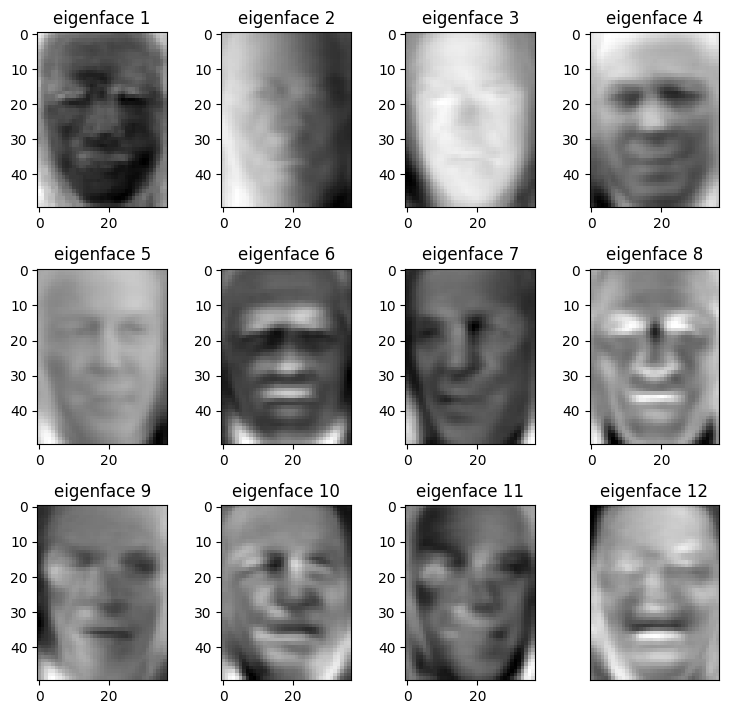

In [22]:
import matplotlib.pyplot as plt

# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """
    Helper function to plot a gallery of portraits.
    """
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

eigenface_titles = [f"eigenface {i + 1}" for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
        
plt.show()

### PCA Compactness

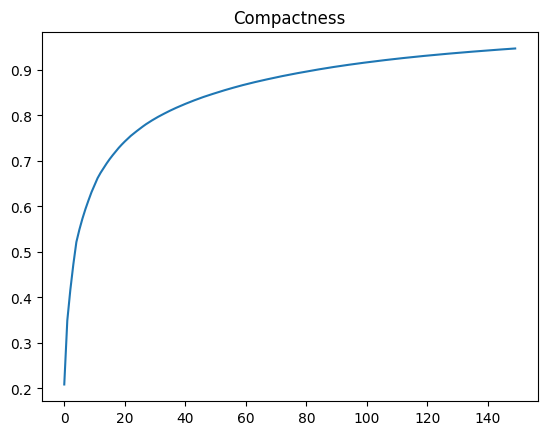

In [23]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
eigenvalueCount = np.arange(n_components)

plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

### Random Forest Classification

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, 
    max_features=150)
estimator.fit(X_train_pca, y_train) # expects X as [n_samples, n_features]

predictions = estimator.predict(X_test_pca)

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.61      0.60      0.61        60
  Donald Rumsfeld       0.60      0.11      0.19        27
    George W Bush       0.63      0.87      0.73       146
Gerhard Schroeder       0.45      0.40      0.43        25
      Hugo Chavez       0.67      0.40      0.50        15
       Tony Blair       0.42      0.28      0.33        36

         accuracy                           0.60       322
        macro avg       0.48      0.38      0.40       322
     weighted avg       0.56      0.60      0.55       322



/home/derenteo/git/comp3710/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/derenteo/git/comp3710/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/derenteo/git/comp3710/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Decoding the classification report:

- `precision`: fraction of correct positive predictions
- `recall`: fraction of correct positive predictions over all positive cases
- `f1-score`: harmonic mean of `precision` and `recall`
- `support`: number of occurrences of the class in the test data